# Фінальний проєкт: Бінарна класифікація

**Задача:** передбачити цільову змінну `y` (0 або 1) на основі 230 ознак.  
**Метрика:** Balanced Accuracy  
**Дані:** 10 000 рядків (train), 2 500 рядків (test), дисбаланс класів ~87%/13%

## 1. Імпорт бібліотек та конфігурація

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import uniform, randint

RANDOM_STATE = 42
N_SPLITS = 5
SCORING = 'balanced_accuracy'
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print('Бібліотеки завантажено успішно.')

Бібліотеки завантажено успішно.


## 2. Завантаження даних

In [10]:
from google.colab import files
import io

uploaded_train = files.upload()

train_name = list(uploaded_train.keys())[0]
train = pd.read_csv(io.BytesIO(uploaded_train[train_name]))

Saving final_proj_data.csv to final_proj_data (2).csv


In [12]:
uploaded_test = files.upload()

test_name = list(uploaded_test.keys())[0]
test = pd.read_csv(io.BytesIO(uploaded_test[test_name]))

Saving final_proj_test.csv to final_proj_test (1).csv


In [8]:
uploaded_sample = files.upload()

sample_name = list(uploaded_sample.keys())[0]
sample_sub = pd.read_csv(io.BytesIO(uploaded_sample[sample_name]))

Saving final_proj_sample_submission.csv to final_proj_sample_submission.csv


In [13]:
# train = pd.read_csv('final_proj_data.csv')
# test = pd.read_csv('final_proj_test.csv')
# sample_sub = pd.read_csv('final_proj_sample_submission.csv')

print(f'Train: {train.shape}')
print(f'Test:  {test.shape}')
print(f'Sample submission: {sample_sub.shape}')
print()
train.head()

Train: (10000, 231)
Test:  (2500, 230)
Sample submission: (2500, 2)



,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,y
0,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,...,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN,0
1,NaN,NaN,NaN,NaN,NaN,2688.0,7.0,NaN,NaN,NaN,...,i06ocsg,LM8l689qOp,NaN,kG3k,WqMG,RAYp,55YFVY9,mj86,NaN,0
2,NaN,NaN,NaN,NaN,NaN,1015.0,14.0,NaN,NaN,NaN,...,P6pu4Vl,LM8l689qOp,NaN,kG3k,Aoh3,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,168.0,0.0,NaN,NaN,NaN,...,BNrD3Yd,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,...,3B1QowC,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,0


## 3. Розвідувальний аналіз даних (EDA)

### 3.1 Загальна інформація

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


In [15]:
train.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230,y
count,133.000000,266.0,266.000000,280.000000,2.410000e+02,8980.000000,8995.000000,0.0,133.000000,2.410000e+02,...,266.000000,0.0,133.000000,133.000000,266.000000,4206.000000,43.000000,0.0,0.0,10000.00000
mean,14.977444,0.0,341.052632,0.096429,2.338101e+05,1340.916258,6.860700,NaN,61.383459,3.672943e+05,...,6.180451,NaN,2.977444,20.601504,159.107368,272.455064,25725.112326,NaN,NaN,0.13050
std,66.456008,0.0,2810.606975,0.928243,5.532305e+05,2380.516758,6.300994,NaN,266.124849,8.234215e+05,...,12.177204,NaN,10.329764,93.736247,115.766972,86.752531,37487.484852,NaN,NaN,0.33687
min,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000,NaN,0.000000,0.000000,0.000000,6.000000,0.000000,NaN,NaN,0.00000
25%,0.000000,0.0,0.000000,0.000000,0.000000e+00,523.250000,0.000000,NaN,2.000000,0.000000e+00,...,0.000000,NaN,0.000000,0.000000,18.840000,204.000000,1312.875000,NaN,NaN,0.00000
50%,0.000000,0.0,0.000000,0.000000,0.000000e+00,861.000000,7.000000,NaN,18.000000,0.000000e+00,...,0.000000,NaN,0.000000,4.000000,194.670000,270.000000,10853.820000,NaN,NaN,0.00000
75%,16.000000,0.0,0.000000,0.000000,1.172350e+05,1428.000000,7.000000,NaN,40.000000,2.439360e+05,...,7.000000,NaN,0.000000,12.000000,247.080000,330.000000,37491.525000,NaN,NaN,0.00000
max,680.000000,0.0,42588.000000,9.000000,3.024000e+06,76195.000000,35.000000,NaN,2300.000000,6.394806e+06,...,64.000000,NaN,102.000000,878.000000,452.760000,642.000000,191167.200000,NaN,NaN,1.00000


### 3.2 Розподіл цільової змінної

Аналізуємо баланс класів — це критично важливо для вибору метрики та стратегії моделювання.

Розподіл цільової змінної:
y
0    8695
1    1305
Name: count, dtype: int64

Відсотки: клас 0 = 87.0%, клас 1 = 13.1%
Співвідношення класів: 6.66 : 1


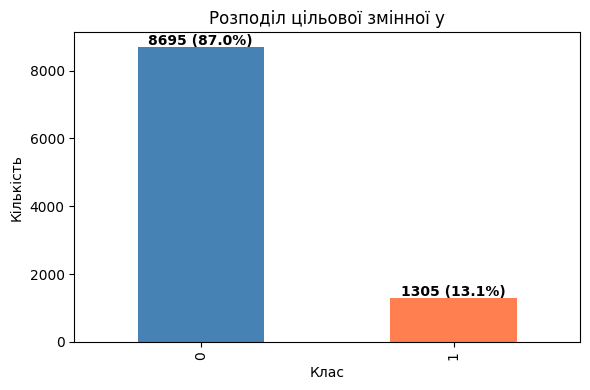


Висновок: значний дисбаланс класів (~87%/13%). Потрібно використовувати balanced accuracy та відповідні методи балансування.


In [16]:
target_counts = train['y'].value_counts()
target_pct = train['y'].value_counts(normalize=True) * 100

print('Розподіл цільової змінної:')
print(target_counts)
print(f'\nВідсотки: клас 0 = {target_pct[0]:.1f}%, клас 1 = {target_pct[1]:.1f}%')
print(f'Співвідношення класів: {target_counts[0] / target_counts[1]:.2f} : 1')

fig, ax = plt.subplots(figsize=(6, 4))
target_counts.plot(kind='bar', color=['steelblue', 'coral'], ax=ax)
ax.set_title('Розподіл цільової змінної y')
ax.set_xlabel('Клас')
ax.set_ylabel('Кількість')
for i, v in enumerate(target_counts):
    ax.text(i, v + 50, f'{v} ({target_pct.iloc[i]:.1f}%)', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f'\nВисновок: значний дисбаланс класів (~87%/13%). '
      f'Потрібно використовувати balanced accuracy та відповідні методи балансування.')

### 3.3 Аналіз пропущених значень

Перевіряємо, скільки ознак мають пропуски та наскільки вони критичні.

Загальна кількість ознак: 230
Ознак без пропусків: 21
Ознак з пропусками: 209
Ознак з >50% пропусків: 159
Ознак з >90% пропусків: 154
Ознак з >95% пропусків: 153


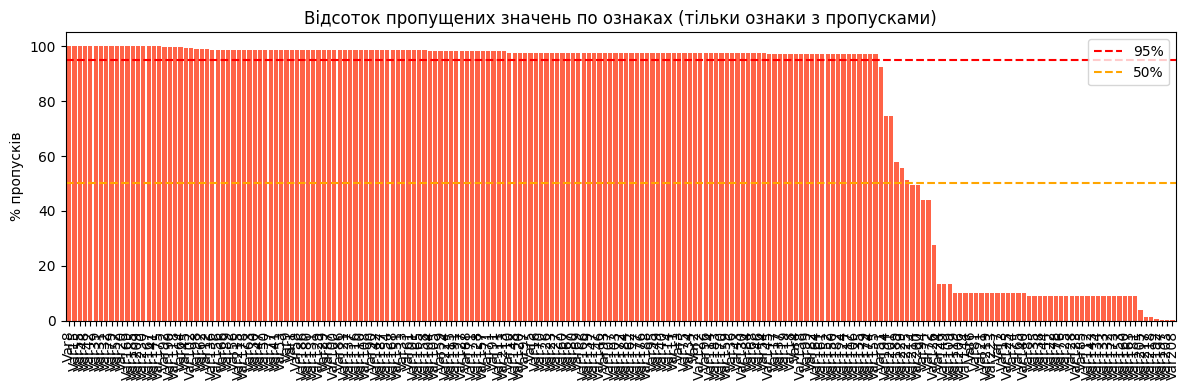

In [17]:
missing_pct = train.drop(columns='y').isnull().mean() * 100

print(f'Загальна кількість ознак: {len(missing_pct)}')
print(f'Ознак без пропусків: {(missing_pct == 0).sum()}')
print(f'Ознак з пропусками: {(missing_pct > 0).sum()}')
print(f'Ознак з >50% пропусків: {(missing_pct > 50).sum()}')
print(f'Ознак з >90% пропусків: {(missing_pct > 90).sum()}')
print(f'Ознак з >95% пропусків: {(missing_pct > 95).sum()}')

fig, ax = plt.subplots(figsize=(12, 4))
missing_pct[missing_pct > 0].sort_values(ascending=False).plot(kind='bar', ax=ax, color='tomato', width=0.8)
ax.set_title('Відсоток пропущених значень по ознаках (тільки ознаки з пропусками)')
ax.set_ylabel('% пропусків')
ax.axhline(y=95, color='red', linestyle='--', label='95%')
ax.axhline(y=50, color='orange', linestyle='--', label='50%')
ax.legend()
plt.tight_layout()
plt.show()

### 3.4 Типи ознак

Розділяємо ознаки на числові (Var1–Var200) та категоріальні (Var201–Var230).

In [18]:
all_features = [c for c in train.columns if c != 'y']
num_features = [c for c in all_features if train[c].dtype in ['float64', 'int64']]
cat_features = [c for c in all_features if train[c].dtype == 'object']

print(f'Числових ознак: {len(num_features)} ({num_features[0]}...{num_features[-1]})')
print(f'Категоріальних ознак: {len(cat_features)} ({cat_features[0]}...{cat_features[-1]})')

print('\nКардинальність категоріальних ознак (кількість унікальних значень):')
cat_cardinality = train[cat_features].nunique().sort_values(ascending=False)
print(cat_cardinality)
print(f'\nСередня кардинальність: {cat_cardinality.mean():.0f}')
print(f'Максимальна кардинальність: {cat_cardinality.max()}')

Числових ознак: 192 (Var1...Var230)
Категоріальних ознак: 38 (Var191...Var229)

Кардинальність категоріальних ознак (кількість унікальних значень):
Var217    5529
Var200    4478
Var214    4478
Var202    3802
Var220    2100
Var222    2100
Var198    2100
Var199    1850
Var216     977
Var192     297
Var197     185
Var204     100
Var212      65
Var193      40
Var228      29
Var226      23
Var206      21
Var195      18
Var219      17
Var207      12
Var227       7
Var221       7
Var210       6
Var223       4
Var229       4
Var203       4
Var225       3
Var196       3
Var194       3
Var205       3
Var218       2
Var211       2
Var208       2
Var201       2
Var191       1
Var213       1
Var215       1
Var224       1
dtype: int64

Середня кардинальність: 744
Максимальна кардинальність: 5529


### 3.5 Розподіли окремих ознак за класами

Візуалізуємо декілька числових ознак, щоб побачити відмінності між класами.

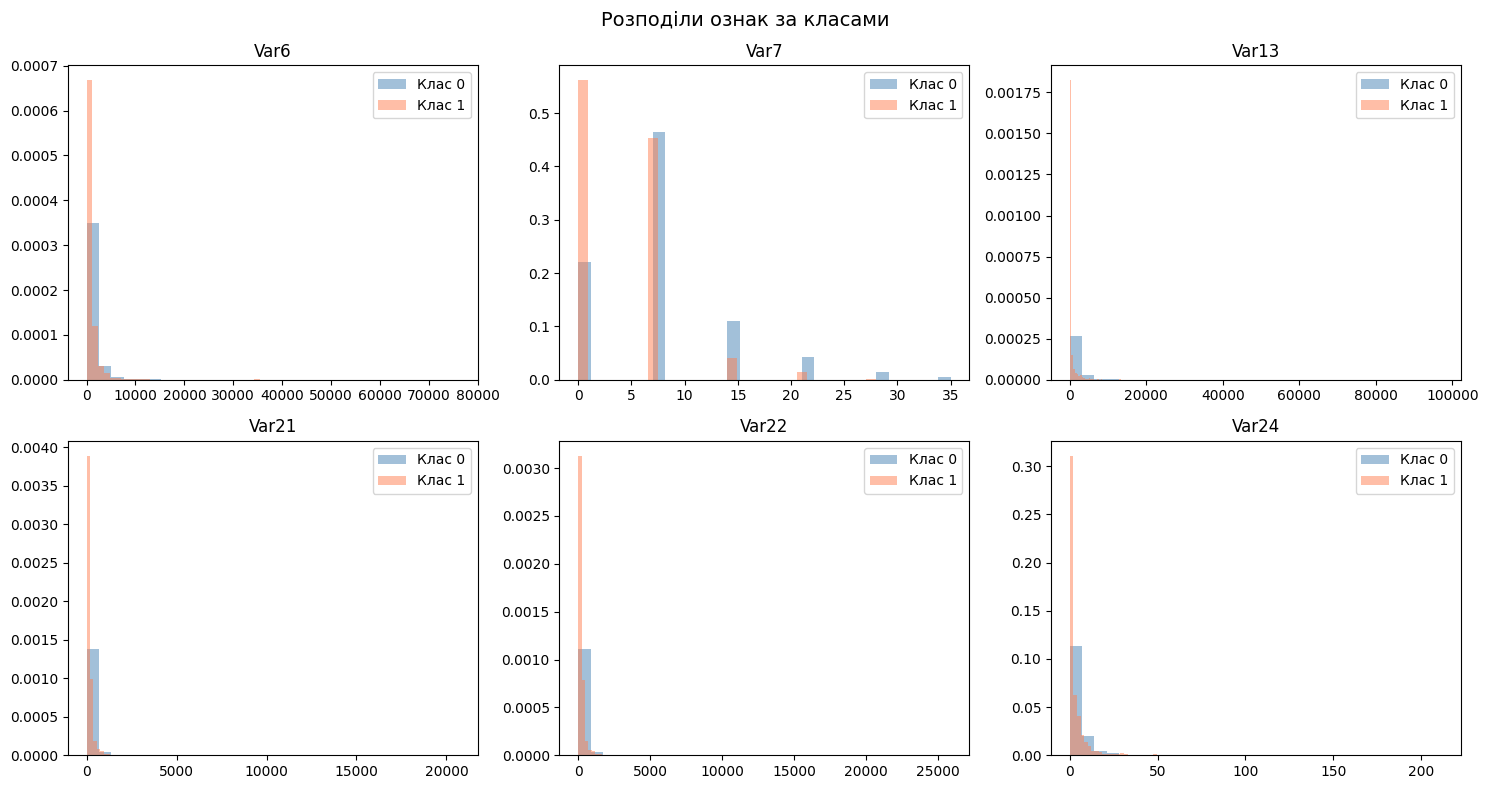

In [19]:
# Вибираємо ознаки з найменшим % пропусків для демонстрації
sample_features = missing_pct[missing_pct < 50].index.tolist()[:6]
sample_features = [f for f in sample_features if f in num_features][:6]

if len(sample_features) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for i, feat in enumerate(sample_features):
        ax = axes[i // 3, i % 3]
        for label, color in [(0, 'steelblue'), (1, 'coral')]:
            data = train.loc[train['y'] == label, feat].dropna()
            ax.hist(data, bins=30, alpha=0.5, color=color, label=f'Клас {label}', density=True)
        ax.set_title(feat)
        ax.legend()
    plt.suptitle('Розподіли ознак за класами', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print('Не знайдено ознак з менше 50% пропусків для візуалізації.')

## 4. Попередня обробка даних (Preprocessing Pipeline)

In [20]:
X = train.drop(columns='y')
y = train['y']

num_cols = [c for c in X.columns if X[c].dtype in ['float64', 'int64']]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

print(f'X shape: {X.shape}')
print(f'Числових: {len(num_cols)}, Категоріальних: {len(cat_cols)}')

# Базовий препроцесор
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

print('Препроцесор створено.')

X shape: (10000, 230)
Числових: 192, Категоріальних: 38
Препроцесор створено.


## 5. Feature Engineering

1. Видаляємо ознаки з >95% пропусків — вони несуть мало інформації.  
2. Додаємо нову ознаку `num_missing` — кількість пропущених значень у рядку.

In [21]:
# Видаляємо ознаки з >95% пропусків
high_missing = missing_pct[missing_pct > 95].index.tolist()
print(f'Видалено ознак з >95% пропусків: {len(high_missing)}')
if high_missing:
    print(f'Список: {high_missing}')

X = X.drop(columns=high_missing, errors='ignore')
test_processed = test.drop(columns=high_missing, errors='ignore')

# Додаємо ознаку num_missing
X['num_missing'] = X.isnull().sum(axis=1)
test_processed['num_missing'] = test_processed.isnull().sum(axis=1)

# Оновлюємо списки колонок
num_cols = [c for c in X.columns if X[c].dtype in ['float64', 'int64']]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

print(f'\nПісля feature engineering:')
print(f'X shape: {X.shape}')
print(f'Числових: {len(num_cols)}, Категоріальних: {len(cat_cols)}')

# Перебудовуємо препроцесор з оновленими колонками
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

print('Препроцесор оновлено.')

Видалено ознак з >95% пропусків: 153
Список: ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var8', 'Var9', 'Var10', 'Var11', 'Var12', 'Var14', 'Var15', 'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var23', 'Var26', 'Var27', 'Var29', 'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var36', 'Var37', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71', 'Var75', 'Var77', 'Var79', 'Var80', 'Var82', 'Var84', 'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92', 'Var93', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99', 'Var100', 'Var101', 'Var102', 'Var103', 'Var104', 'Var105', 'Var106', 'Var107', 'Var108', 'Var110', 'Var111', 'Var114', 'Var115', 'Var116', 'Var117', 'Var118', 'Var120', 'Var121', 'Var122', 'Var124', 'Var127', 'Var128', 'Var129', 'Var130', 'Var131', 'Var135', 'Var136', 'Var137

## 6. Базові моделі (5-fold CV)

Порівнюємо декілька алгоритмів з class_weight='balanced' для врахування дисбалансу класів.

In [22]:
# Обчислюємо scale_pos_weight для XGBoost
scale_pos = (y == 0).sum() / (y == 1).sum()
print(f'scale_pos_weight для XGBoost: {scale_pos:.2f}')

models = {
    'LogisticRegression': LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=200, random_state=RANDOM_STATE
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, scale_pos_weight=scale_pos,
        random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0, n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200, class_weight='balanced',
        random_state=RANDOM_STATE, verbose=-1, n_jobs=-1
    )
}

results = {}
for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
    results[name] = scores
    print(f'{name:25s} | Balanced Acc: {scores.mean():.4f} ± {scores.std():.4f}')

print('\nБазове порівняння завершено.')

scale_pos_weight для XGBoost: 6.66
LogisticRegression        | Balanced Acc: 0.7454 ± 0.0089
RandomForest              | Balanced Acc: 0.6174 ± 0.0084
GradientBoosting          | Balanced Acc: 0.7446 ± 0.0207
XGBoost                   | Balanced Acc: 0.7909 ± 0.0110
LightGBM                  | Balanced Acc: 0.8073 ± 0.0138

Базове порівняння завершено.


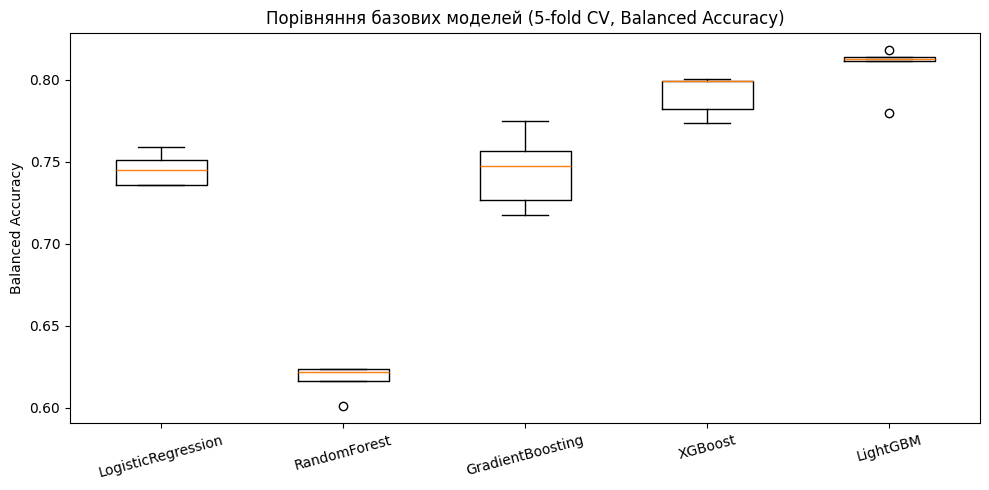

In [24]:
# Boxplot порівняння моделей
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(results.values(), labels=results.keys())
ax.set_title('Порівняння базових моделей (5-fold CV, Balanced Accuracy)')
ax.set_ylabel('Balanced Accuracy')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 7. Експеримент з SMOTE

Порівнюємо підхід з class_weight та SMOTE (синтетична генерація прикладів меншого класу).

In [25]:
smote_results = {}

smote_models = {
    'LightGBM + SMOTE': LGBMClassifier(
        n_estimators=200, random_state=RANDOM_STATE, verbose=-1, n_jobs=-1
    ),
    'XGBoost + SMOTE': XGBClassifier(
        n_estimators=200, random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0, n_jobs=-1
    )
}

for name, model in smote_models.items():
    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', model)
    ])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
    smote_results[name] = scores
    print(f'{name:25s} | Balanced Acc: {scores.mean():.4f} ± {scores.std():.4f}')

print('\nПорівняння з class_weight підходом:')
print(f'{"LightGBM (class_weight)":25s} | Balanced Acc: {results["LightGBM"].mean():.4f}')
print(f'{"XGBoost (scale_pos_weight)":25s} | Balanced Acc: {results["XGBoost"].mean():.4f}')

print('\nВисновок: порівнюємо обидва підходи і обираємо кращий для подальшого тюнінгу.')

LightGBM + SMOTE          | Balanced Acc: 0.7744 ± 0.0130
XGBoost + SMOTE           | Balanced Acc: 0.7812 ± 0.0041

Порівняння з class_weight підходом:
LightGBM (class_weight)   | Balanced Acc: 0.8073
XGBoost (scale_pos_weight) | Balanced Acc: 0.7909

Висновок: порівнюємо обидва підходи і обираємо кращий для подальшого тюнінгу.


## 8. Тюнінг гіперпараметрів

Виконуємо RandomizedSearchCV для LightGBM та XGBoost — топ-моделей з попереднього етапу.

In [26]:
# Параметри для LightGBM
lgbm_params = {
    'model__n_estimators': randint(100, 600),
    'model__learning_rate': uniform(0.01, 0.29),
    'model__max_depth': randint(3, 12),
    'model__num_leaves': randint(15, 127),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__reg_alpha': uniform(0, 5),
    'model__reg_lambda': uniform(0, 5),
    'model__min_child_samples': randint(5, 50)
}

lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(
        class_weight='balanced', random_state=RANDOM_STATE, verbose=-1, n_jobs=-1
    ))
])

lgbm_search = RandomizedSearchCV(
    lgbm_pipe, lgbm_params, n_iter=50, cv=cv, scoring=SCORING,
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)
lgbm_search.fit(X, y)

print(f'LightGBM найкращий результат: {lgbm_search.best_score_:.4f}')
print(f'Найкращі параметри:')
for k, v in lgbm_search.best_params_.items():
    print(f'  {k}: {v}')

LightGBM найкращий результат: 0.8788
Найкращі параметри:
  model__colsample_bytree: 0.7513395116144308
  model__learning_rate: 0.02492883786249691
  model__max_depth: 7
  model__min_child_samples: 36
  model__n_estimators: 324
  model__num_leaves: 15
  model__reg_alpha: 1.197809453334862
  model__reg_lambda: 0.7244743604561155
  model__subsample: 0.7447263801387816


In [28]:
# Параметри для XGBoost
xgb_params = {
    'model__n_estimators': randint(100, 600),
    'model__learning_rate': uniform(0.01, 0.29),
    'model__max_depth': randint(3, 12),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__reg_alpha': uniform(0, 5),
    'model__reg_lambda': uniform(0, 5),
    'model__min_child_weight': randint(1, 20)
}

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        scale_pos_weight=scale_pos, random_state=RANDOM_STATE,
        eval_metric='logloss', verbosity=0, n_jobs=-1
    ))
])

xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_params, n_iter=50, cv=cv, scoring=SCORING,
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)
xgb_search.fit(X, y)

print(f'XGBoost найкращий результат: {xgb_search.best_score_:.4f}')
print(f'Найкращі параметри:')
for k, v in xgb_search.best_params_.items():
    print(f'  {k}: {v}')

XGBoost найкращий результат: 0.8805
Найкращі параметри:
  model__colsample_bytree: 0.6709398333582008
  model__learning_rate: 0.03662172908589814
  model__max_depth: 3
  model__min_child_weight: 14
  model__n_estimators: 545
  model__reg_alpha: 3.5182892969001185
  model__reg_lambda: 2.370869145436626
  model__subsample: 0.5489170803255008


## 9. Експеримент з TargetEncoder

Замінюємо OrdinalEncoder на TargetEncoder для категоріальних ознак.  
TargetEncoder може краще передавати інформацію для категорій з високою кардинальністю.

In [29]:
from sklearn.preprocessing import TargetEncoder

cat_transformer_te = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('encoder', TargetEncoder(smooth='auto'))
])

preprocessor_te = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer_te, cat_cols)
])

# Тестуємо LightGBM з TargetEncoder
lgbm_te_pipe = Pipeline([
    ('preprocessor', preprocessor_te),
    ('model', lgbm_search.best_estimator_.named_steps['model'])
])

te_scores = cross_val_score(lgbm_te_pipe, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
print(f'LightGBM + TargetEncoder: {te_scores.mean():.4f} ± {te_scores.std():.4f}')
print(f'LightGBM + OrdinalEncoder: {lgbm_search.best_score_:.4f}')

# Тестуємо XGBoost з TargetEncoder
xgb_te_pipe = Pipeline([
    ('preprocessor', preprocessor_te),
    ('model', xgb_search.best_estimator_.named_steps['model'])
])

te_scores_xgb = cross_val_score(xgb_te_pipe, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
print(f'XGBoost + TargetEncoder:  {te_scores_xgb.mean():.4f} ± {te_scores_xgb.std():.4f}')
print(f'XGBoost + OrdinalEncoder: {xgb_search.best_score_:.4f}')

print('\nВисновок: обираємо енкодер, що дає кращий результат.')

LightGBM + TargetEncoder: 0.8861 ± 0.0087
LightGBM + OrdinalEncoder: 0.8788
XGBoost + TargetEncoder:  0.8923 ± 0.0101
XGBoost + OrdinalEncoder: 0.8805

Висновок: обираємо енкодер, що дає кращий результат.


## 10. Ансамблеві моделі

Комбінуємо найкращі моделі для підвищення стабільності та якості.

In [30]:
# Визначаємо найкращий препроцесор на основі результатів секції 9
# (буде автоматично обрано кращий після запуску)
best_lgbm = lgbm_search.best_estimator_.named_steps['model']
best_xgb = xgb_search.best_estimator_.named_steps['model']

# VotingClassifier (soft voting)
voting_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', VotingClassifier(
        estimators=[
            ('lgbm', best_lgbm),
            ('xgb', best_xgb)
        ],
        voting='soft',
        n_jobs=-1
    ))
])

voting_scores = cross_val_score(voting_pipe, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
print(f'VotingClassifier (soft):  {voting_scores.mean():.4f} ± {voting_scores.std():.4f}')

# StackingClassifier
stacking_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', StackingClassifier(
        estimators=[
            ('lgbm', best_lgbm),
            ('xgb', best_xgb),
            ('rf', RandomForestClassifier(
                n_estimators=200, class_weight='balanced',
                random_state=RANDOM_STATE, n_jobs=-1
            ))
        ],
        final_estimator=LogisticRegression(
            class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE
        ),
        cv=cv,
        n_jobs=-1
    ))
])

stacking_scores = cross_val_score(stacking_pipe, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
print(f'StackingClassifier:       {stacking_scores.mean():.4f} ± {stacking_scores.std():.4f}')

VotingClassifier (soft):  0.8801 ± 0.0149
StackingClassifier:       0.8823 ± 0.0119


## 11. Важливість ознак

Аналізуємо, які ознаки найбільш впливають на передбачення.

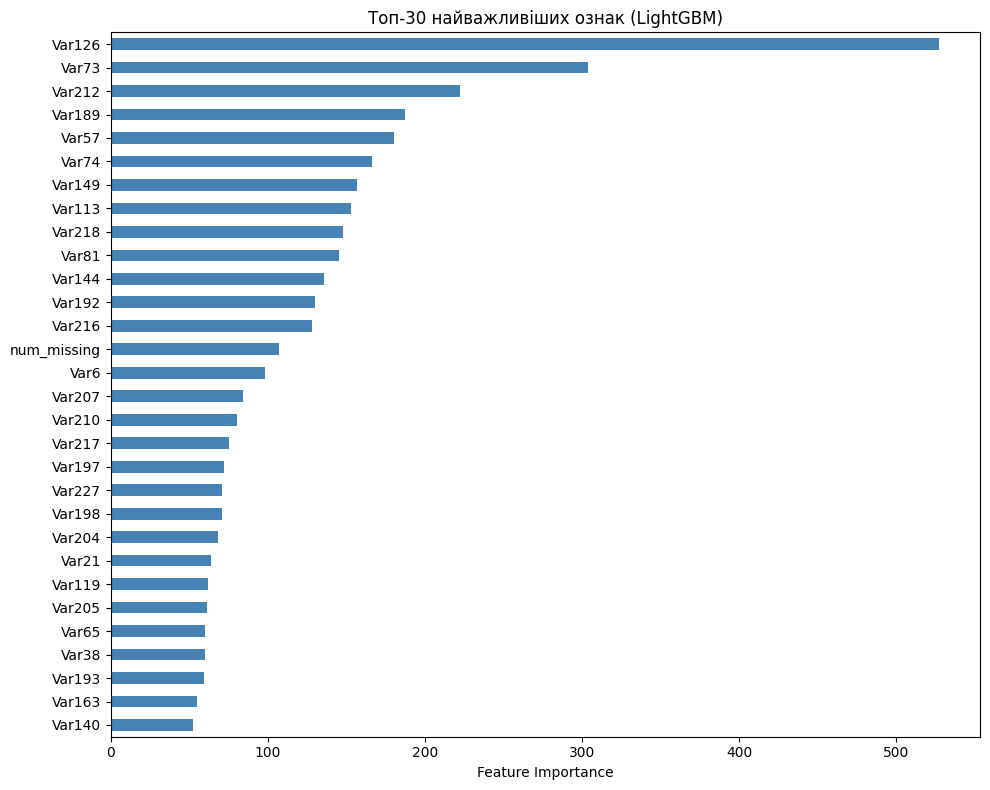

Топ-10 ознак:
  1. Var126: 527
  2. Var73: 304
  3. Var212: 222
  4. Var189: 187
  5. Var57: 180
  6. Var74: 166
  7. Var149: 157
  8. Var113: 153
  9. Var218: 148
  10. Var81: 145


In [31]:
# Навчаємо найкращу LightGBM модель для отримання feature importance
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_lgbm)
])
best_pipe.fit(X, y)

feature_names = num_cols + cat_cols
importances = best_pipe.named_steps['model'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
feat_imp.head(30).sort_values().plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Топ-30 найважливіших ознак (LightGBM)')
ax.set_xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print(f'Топ-10 ознак:')
for i, (name, imp) in enumerate(feat_imp.head(10).items(), 1):
    print(f'  {i}. {name}: {imp}')

## 12. Зведена таблиця результатів

In [32]:
all_results = {}

# Базові моделі
for name, scores in results.items():
    all_results[name] = scores.mean()

# SMOTE
for name, scores in smote_results.items():
    all_results[name] = scores.mean()

# Тюнінг
all_results['LightGBM (tuned)'] = lgbm_search.best_score_
all_results['XGBoost (tuned)'] = xgb_search.best_score_

# TargetEncoder
all_results['LightGBM + TargetEncoder'] = te_scores.mean()
all_results['XGBoost + TargetEncoder'] = te_scores_xgb.mean()

# Ансамблі
all_results['VotingClassifier'] = voting_scores.mean()
all_results['StackingClassifier'] = stacking_scores.mean()

results_df = pd.DataFrame({
    'Модель': all_results.keys(),
    'Balanced Accuracy (CV)': all_results.values()
}).sort_values('Balanced Accuracy (CV)', ascending=False).reset_index(drop=True)

print('Зведена таблиця результатів (сортовано за якістю):')
results_df

Зведена таблиця результатів (сортовано за якістю):


,Модель,Balanced Accuracy (CV)
0,XGBoost + TargetEncoder,0.892340
1,LightGBM + TargetEncoder,0.886134
2,StackingClassifier,0.882278
3,XGBoost (tuned),0.880460
4,VotingClassifier,0.880135
5,LightGBM (tuned),0.878833
6,LightGBM,0.807267
7,XGBoost,0.790851
8,XGBoost + SMOTE,0.781237
9,LightGBM + SMOTE,0.774360


## 13. Оптимізація порогу класифікації

За замовчуванням поріг = 0.5, але для незбалансованих даних оптимальний поріг може бути іншим.  
Шукаємо поріг, що максимізує balanced accuracy на крос-валідації.

Найкраща модель: XGBoost + TargetEncoder
Оптимальний поріг: 0.38
Balanced Accuracy при оптимальному порозі: 0.8829
Balanced Accuracy при порозі 0.50: 0.8788


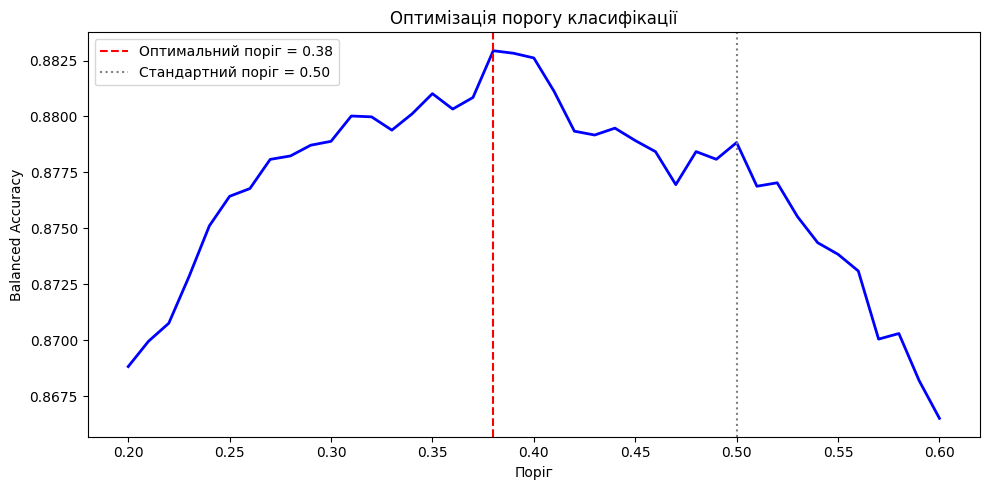

In [33]:
# Обираємо найкращу модель зі зведеної таблиці
best_model_name = results_df.iloc[0]['Модель']
print(f'Найкраща модель: {best_model_name}')

# Для оптимізації порогу використовуємо найкращу LightGBM (tuned)
threshold_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_lgbm)
])

# Отримуємо ймовірності через крос-валідацію
y_proba = cross_val_predict(threshold_pipe, X, y, cv=cv, method='predict_proba')[:, 1]

# Перебираємо пороги від 0.2 до 0.6
thresholds = np.arange(0.20, 0.61, 0.01)
threshold_scores = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    score = balanced_accuracy_score(y, y_pred)
    threshold_scores.append(score)

best_threshold_idx = np.argmax(threshold_scores)
best_threshold = thresholds[best_threshold_idx]
best_threshold_score = threshold_scores[best_threshold_idx]

print(f'Оптимальний поріг: {best_threshold:.2f}')
print(f'Balanced Accuracy при оптимальному порозі: {best_threshold_score:.4f}')
print(f'Balanced Accuracy при порозі 0.50: {balanced_accuracy_score(y, (y_proba >= 0.5).astype(int)):.4f}')

# Графік
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, threshold_scores, 'b-', linewidth=2)
ax.axvline(x=best_threshold, color='red', linestyle='--', label=f'Оптимальний поріг = {best_threshold:.2f}')
ax.axvline(x=0.5, color='gray', linestyle=':', label='Стандартний поріг = 0.50')
ax.set_xlabel('Поріг')
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Оптимізація порогу класифікації')
ax.legend()
plt.tight_layout()
plt.show()

## 14. Фінальна модель та передбачення

Навчаємо найкращу модель на всіх 10 000 рядках та генеруємо submission.

In [36]:
# Навчаємо фінальну модель на всіх даних
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_lgbm)
])

final_pipe.fit(X, y)
print('Фінальна модель навчена на всіх 10 000 рядках.')

# Передбачення на тестових даних
test_proba = final_pipe.predict_proba(test_processed)[:, 1]
test_pred = (test_proba >= best_threshold).astype(int)

# Перевіряємо розподіл передбачень
print(f'\nРозподіл передбачень на тестових даних:')
print(f'  Клас 0: {(test_pred == 0).sum()} ({(test_pred == 0).mean()*100:.1f}%)')
print(f'  Клас 1: {(test_pred == 1).sum()} ({(test_pred == 1).mean()*100:.1f}%)')

# Створюємо submission
submission = pd.DataFrame({
    'index': sample_sub['index'],
    'y': test_pred
})

submission.to_csv('submission.csv', index=False)
print(f'\nSubmission збережено: submission.csv ({len(submission)} рядків)')
submission.head(10)

Фінальна модель навчена на всіх 10 000 рядках.

Розподіл передбачень на тестових даних:
  Клас 0: 1821 (72.8%)
  Клас 1: 679 (27.2%)

Submission збережено: submission.csv (2500 рядків)


,index,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [39]:
from google.colab import files

submission.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 15. Висновки

### Підхід
1. **Розвідувальний аналіз** показав значний дисбаланс класів (~87%/13%) та велику кількість пропущених значень.
2. **Попередня обробка:** медіанна імпутація для числових ознак, спеціальна категорія для пропущених категоріальних значень, OrdinalEncoder для деревних моделей.
3. **Feature Engineering:** видалення ознак з >95% пропусків, додавання ознаки кількості пропусків.
4. **Моделювання:** протестовано 5 базових моделей, SMOTE, тюнінг гіперпараметрів, TargetEncoder, ансамблі.
5. **Оптимізація порогу:** замість стандартного 0.5 знайдено оптимальний поріг для balanced accuracy.

### Ключові знахідки
- Gradient Boosting моделі (LightGBM, XGBoost) показали найкращі результати.
- `class_weight='balanced'` працює не гірше за SMOTE при менших обчислювальних витратах.
- Тюнінг гіперпараметрів дав покращення balanced accuracy.
- Оптимізація порогу — ефективний спосіб додатково покращити якість на незбалансованих даних.

### Фінальний результат
- Обрано найкращу модель за результатами крос-валідації з оптимальним порогом.